# Advanced Lane Finding Project

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

### Sample Image

(896, 1600, 3)


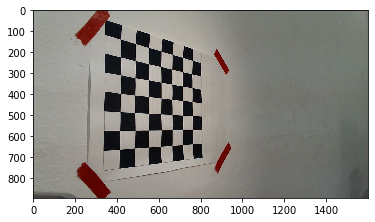

In [2]:
img = mpimg.imread('img/chessboard/WIN_20201016_12_07_45_Pro.jpg')
image_shape = img.shape
print(image_shape)
plt.imshow(img)

### Camera Calibration

In [3]:
nx = 7 #number of corners in a row
ny = 7 #number of corners in a column

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

fnames = glob.glob("img/chessboard/*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)

In [4]:
print("ret", ret)
print("cameraMatrix", cameraMatrix)
print("distortionCoeffs", distortionCoeffs)
print("rvecs", rvecs)
print("tvecs", tvecs)

ret 1.4283446322145903
cameraMatrix [[1.41412089e+03 0.00000000e+00 7.92601447e+02]
 [0.00000000e+00 1.35444389e+03 4.45674968e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortionCoeffs [[-0.00856247  0.35005893 -0.00291822  0.00292694 -2.26954068]]
rvecs [array([[-0.09445515],
       [-0.91665168],
       [ 0.03436005]]), array([[-0.09268866],
       [-0.97814381],
       [ 0.03673634]]), array([[-0.09390224],
       [-0.76971072],
       [ 0.02337511]]), array([[-0.0935846 ],
       [-0.64517849],
       [ 0.01323384]]), array([[-0.09126547],
       [-0.53450284],
       [ 0.00615122]]), array([[-0.08998382],
       [-0.4398024 ],
       [-0.0007726 ]]), array([[-0.09450647],
       [-0.34749626],
       [-0.00706186]]), array([[-0.09019397],
       [-0.2092961 ],
       [-0.01736604]]), array([[-0.09587569],
       [-0.1830375 ],
       [-0.0223751 ]]), array([[-0.08425908],
       [-0.053774  ],
       [-0.02892692]]), array([[-0.08266145],
       [ 0.00016398],
       

### Example

(896, 1600, 3)


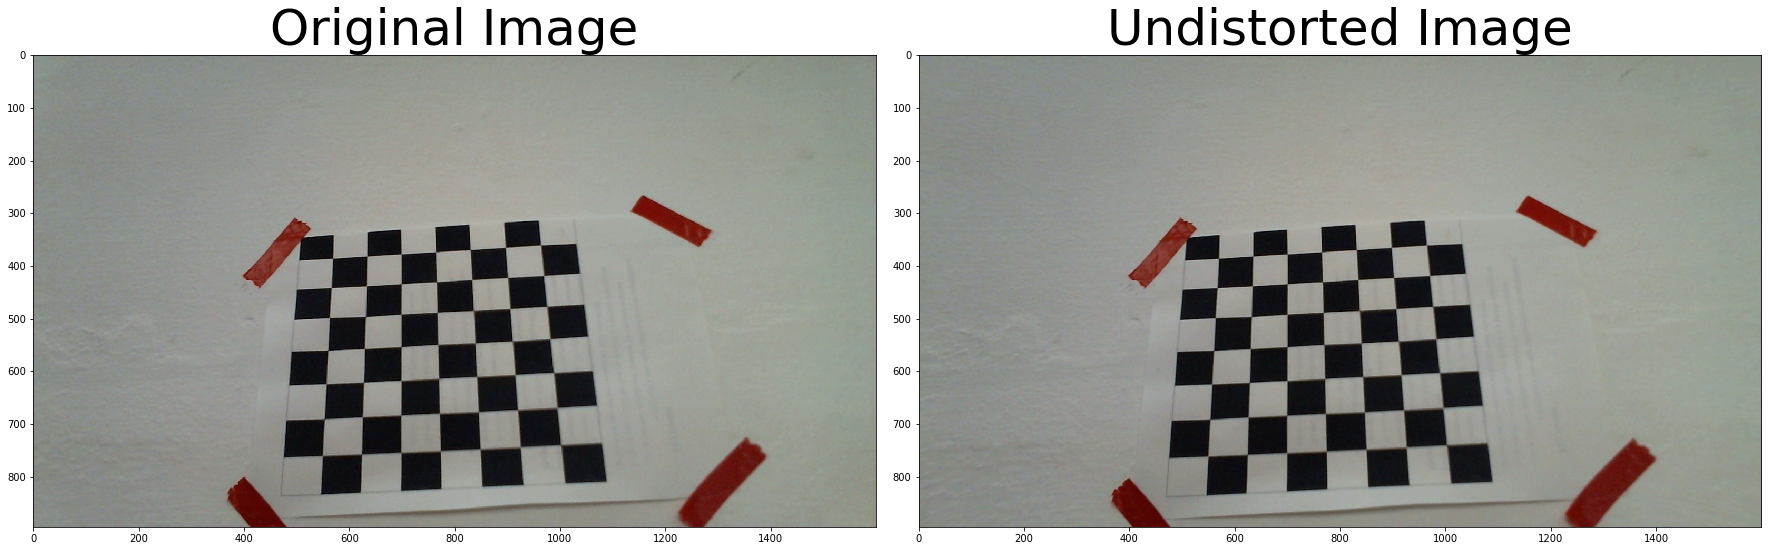

In [5]:
img = mpimg.imread('img/chessboard/WIN_20201016_12_24_44_Pro.jpg')
print(img.shape)
undistorted = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Thresholding

In [10]:
def get_thresholded_image(img):
    
    #img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 200
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)

    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    h = hls[:,:,0]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (200, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (200, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    #color_combined[(s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[(0, 896),(550, 420), (1050, 420), (1600, 896)]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
    
    
    
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

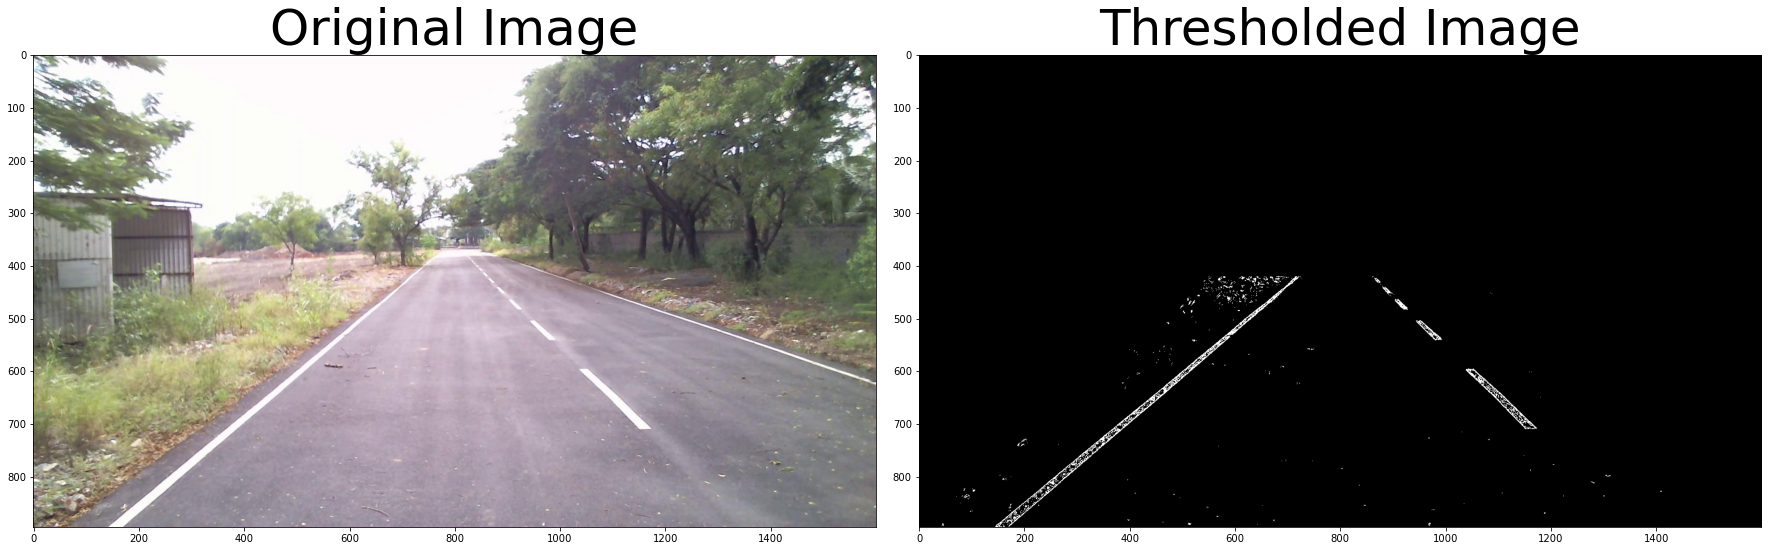

In [11]:
img = mpimg.imread('img/test7.jpg')
thresholded = get_thresholded_image(img)
#img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
#cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective Transform

(896, 1600, 3)


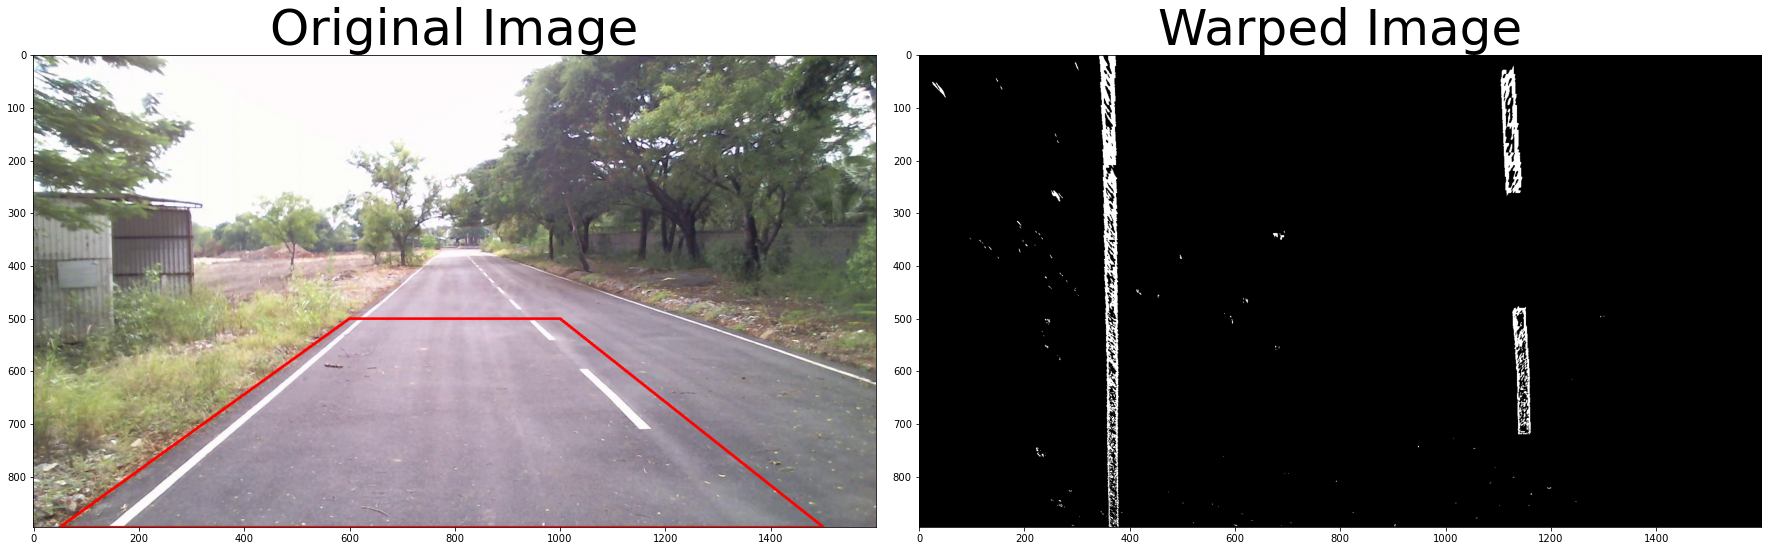

In [17]:
image_shape = img.shape
print(image_shape)
# Vertices extracted manually for performing a perspective transform
bottom_left = [50, 896]
bottom_right = [1500, 896]
top_left = [600, 500]
top_right = [1000, 500]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [300,896]
bottom_right = [1250, 896]
top_left = [300, 0]
top_right = [1250, 0]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Histogram

376 1137


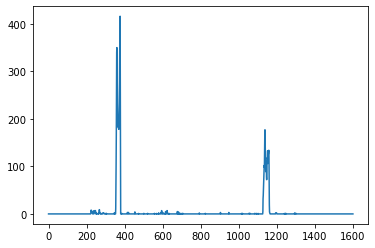

In [18]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)

### Sliding Window Search

(896.0, 0.0)

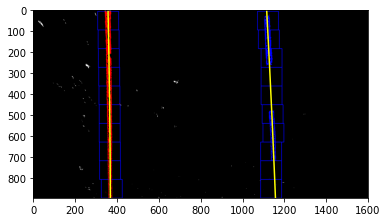

In [19]:
out_img = np.dstack((warped, warped, warped))*255

non_zeros = warped.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]

num_windows = 10
num_rows = warped.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50

min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height
    
    left_x_min = leftx_base - window_half_width
    left_x_max = leftx_base + window_half_width
    
    cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
    
    good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    
    if len(good_left_window_coordinates) > min_pixels:
        leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
    
    right_x_min = rightx_base - window_half_width
    right_x_max = rightx_base + window_half_width
    
    cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
    
    good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
        
    if len(good_right_window_coordinates) > min_pixels:
        rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

plt.imshow(out_img)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

### Searching Around a previous line

(896.0, 0.0)

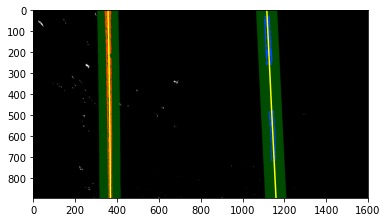

In [20]:
margin = 50
out_img = np.dstack((warped, warped, warped))*255

left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]


left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

window_img = np.zeros_like(out_img)

left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))

left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))

left_line_points = np.vstack((left_line_window_1, left_line_window_2))

cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])

right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))

right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))

right_line_points = np.vstack((right_line_window_1, right_line_window_2))

cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

### Radius of Curvature and Center Offset

In [22]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 33/896 # meters per pixel in y dimension
    xm_per_pix = 3.80/1600 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_x_predictions)
right_curve_rad = measure_radius_of_curvature(right_x_predictions)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
xm_per_pix = 4.05/1600 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 75512.05 m
Center offset: 0.10 m


### Output Image

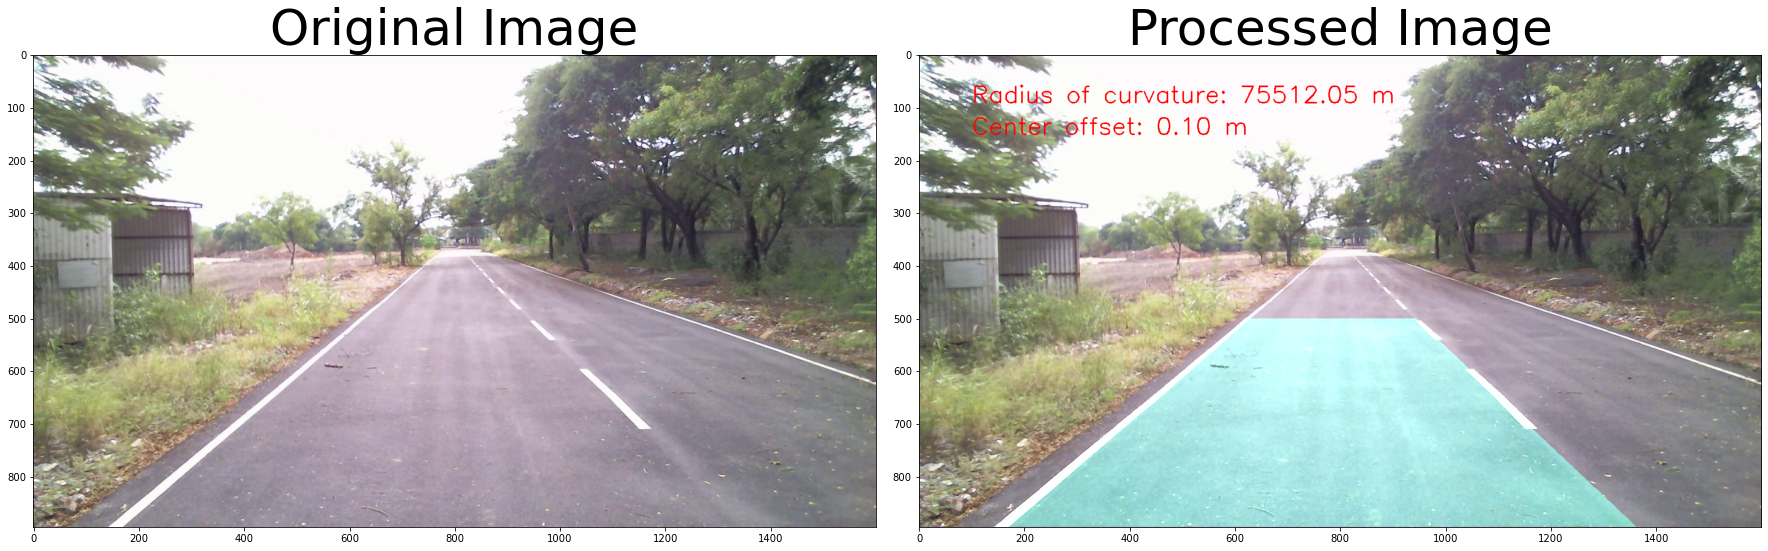

In [23]:
out_img = np.dstack((warped, warped, warped))*255

y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(out_img, np.int_([line_points]), [0, 255, 196])

unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), thickness=2)
cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), thickness=2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [24]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

running_mean_difference_between_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def brute_search(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    # get thresholded image
    thresholded = get_thresholded_image(img)
    
    # perform a perspective transform
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 4/1080 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    #result = unwarped
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

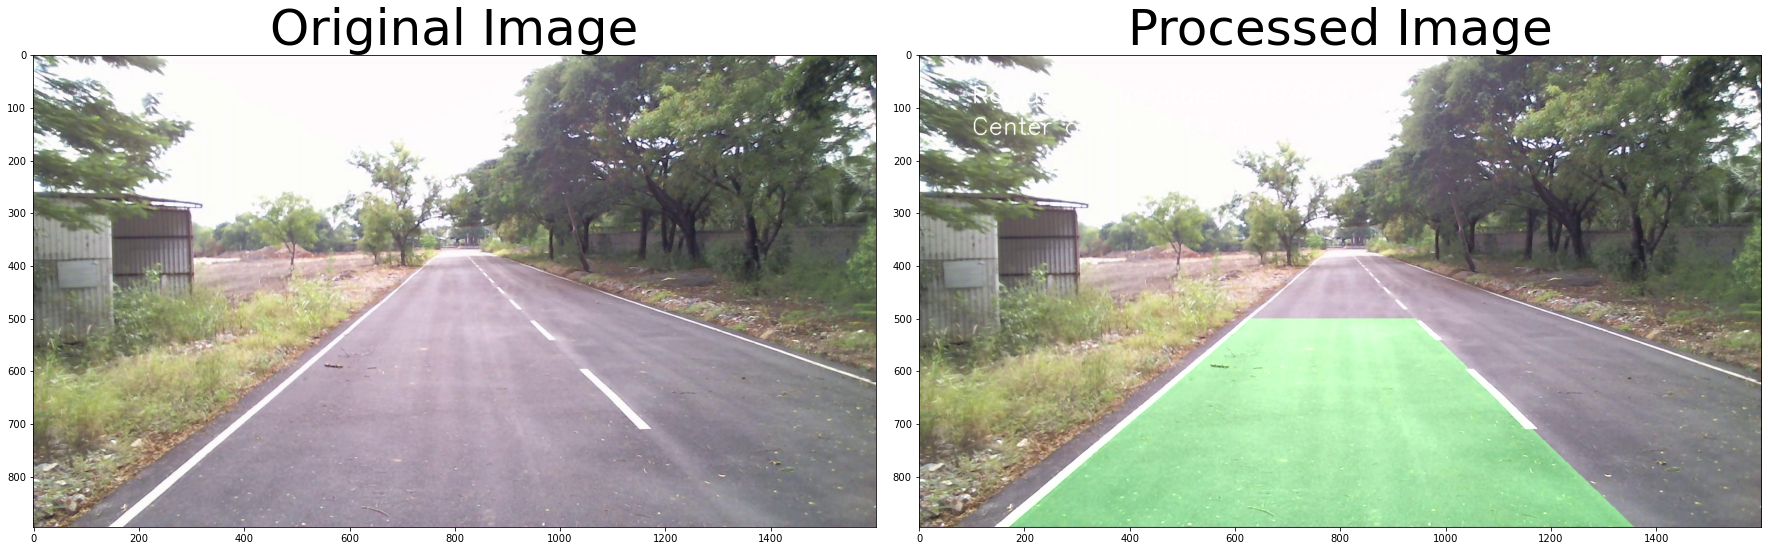

In [25]:
img = mpimg.imread('img/test7.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave('img/output.jpg',processed,cmap="gray")

In [2]:
from moviepy.editor import VideoFileClip

In [26]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'img/test_vid_output.mp4'
clip1 = VideoFileClip("img/test_vid_b.mp4").subclip(0,10)
#clip1.save_frame("img/test7.jpg",t=2)
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

t:   0%|                                                                             | 0/300 [00:00<?, ?it/s, now=None]

Moviepy - Building video img/test_vid_output.mp4.
Moviepy - Writing video img/test_vid_output.mp4



Moviepy - Done !
Moviepy - video ready img/test_vid_output.mp4
Wall time: 1min 58s
